In [1]:
import numpy as np 
import scipy.optimize
import matplotlib.pyplot as plt
import time

In [2]:
# Material properties
# YM: Young's Modulus [N/mm²]
# v: Poisson's ratio
# sigma_y: initial yield limit [N/mm²]
E, v, sigma_y = 2e5, 0.3, 250

## Isotropic hardening
# Q_iso: Isotropic asymptote [ 80 N/mm²] 
# n_iso: exponent [3]
# b_iso: growth rate [10]
# D_iso: limit [170 N/mm²]
Q_iso, n_iso, b_iso, D_iso = 50, 2, 100, 50

## Kinematic hardening
# Q_kin = Kinematic asymptote [N/mm²]
# b_kin: growth rate
Q_kin, b_kin = 0, 0

In [3]:
# maximum strain in x direction
strain_x_max = 5e-2

time_to_strain_x_max = 1

strain_rate = strain_x_max/time_to_strain_x_max

In [4]:
def strain(t):
    return strain_rate*t if t < time_to_strain_x_max else strain_x_max

In [5]:
def func_strain_rate(t):
    return strain_rate if t < time_to_strain_x_max else 0

In [6]:
def equivalent_stress(sigma, backstress):

    sigma_xx = sigma - backstress

    return np.sqrt(sigma_xx**2)

In [7]:
def sigma_macaulay(sigma, backstress, K, power):

    sigma_ex = equivalent_stress(sigma, backstress) - (sigma_y + K)

    return (sigma_ex/D_iso)**power if sigma_ex > 0 else 0

# Implicit scheme

$\left[\begin{array}{c}
\boldsymbol{F}\\
g\\
\boldsymbol{H} \end{array}\right] =
\left[\begin{array}{c}
\boldsymbol{\varepsilon}_{i+1} - \boldsymbol{\varepsilon}_{i} - \Delta t \cdot\left\{\boldsymbol{E}^{-1} \cdot \big( \frac{\boldsymbol{\sigma}_{i+1}-\boldsymbol{\sigma}_{i}}{\Delta t}\big )+\frac{1}{\sigma_{v, i+1}} \cdot\left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} \cdot \dot{\boldsymbol{\varepsilon}}_{0} \cdot \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i+1} - \boldsymbol{X}_{i+1})\right\} \\
K_{i+1}-K_{i}-\Delta t \cdot b_{iso} \cdot\left(Q_{iso}-K_{i+1}\right) \cdot\left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} \\
\boldsymbol{X}_{i+1} - \boldsymbol{X}_{i} - \Delta t \cdot b_{kin} \cdot \Big (\frac{2}{3} Q_{kin} \cdot \frac{1}{\sigma_{v, i+1}} \boldsymbol{M} \cdot (\boldsymbol{\sigma}_{i+1} - \boldsymbol{X}_{i+1}) - \boldsymbol{X}_{i+1} \Big) \cdot \left\langle\frac{\sigma_{e x, i+1}}{D}\right\rangle^{n} 
\end{array}\right]$

In [8]:
def system_of_functions(Z, delta_t, sigma_i, t0, K_i, X_i):

    sigma_i_plus_1 = Z[0]
    K_i_plus_1 = Z[1]
    X_i_plus_1 = Z[2]

    # Plane stress
    fa = strain(t0 + delta_t) - strain(t0) # [scalar]
    fb = (1/E) * ((sigma_i_plus_1-sigma_i)/delta_t) # [scalar]
    fc = 1/equivalent_stress(sigma_i_plus_1, X_i_plus_1) # [scalar]
    fd = sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso) # [scalar]
    fe = (sigma_i_plus_1 - X_i_plus_1) # [scalar]

    F = fa - delta_t * (fb + fc * fd * fe) # [3,1]

    g = K_i_plus_1 - K_i - delta_t * b_iso * (Q_iso - K_i_plus_1) * fd # [scalar]

    H = X_i_plus_1 - X_i - delta_t * b_kin * ( (2/3) * Q_kin * fc * fe - X_i_plus_1) * fd # [scalar]

    return np.array([F, g, H]) # [3,1]

In [9]:
def fd_plus_jac(Z_prime, delta_t, sigma_i, t0, K_i, X_i):

    sigma_i_plus_1 = Z_prime[0]
    K_i_plus_1 = Z_prime[1]
    X_i_plus_1 = Z_prime[2]

    ## common terms

    # functions 
    fc = 1/equivalent_stress(sigma_i_plus_1, X_i_plus_1) # [scalar]
    fd = sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso) # [scalar]
    fe = sigma_i_plus_1 - X_i_plus_1 # [scalar]

    dsigmaMac_dsigmaex = n_iso * (1/D_iso) * sigma_macaulay(sigma_i_plus_1, X_i_plus_1, K_i_plus_1, n_iso-1) #[scalar]

    # derivatives wrt K
    dsigmaex_dK = -1 # [scalar]
    dfd_dK = dsigmaMac_dsigmaex * dsigmaex_dK # [scalar]

    # direct derivatives
    dsigmav_dsigma = fc * (sigma_i_plus_1 - X_i_plus_1) # [scalar]
    dfc_dsigma = - (fc**2) * dsigmav_dsigma # [scalar]
    dsigmaex_dsigma = dsigmav_dsigma # [scalar]
    dfd_dsigma = dsigmaMac_dsigmaex * dsigmaex_dsigma # [scalar]
    dfe_dsigma = 1 # [scalar]

    dsigmav_dX = - dsigmav_dsigma # [scalar]
    dfc_dX = - (fc**2) * dsigmav_dX # [scalar]
    dsigmaex_dX = dsigmav_dX # [scalar]
    dfd_dX = dsigmaMac_dsigmaex * dsigmaex_dX # [scalar]
    dfe_dX = -1 # [scalar]

    # Jacobian Assembly
    J = np.zeros((3,3))

    # derivatives of vector function F
    
    # [1,1]
    J[0, 0] = - delta_t* ( (1/delta_t) * (1/E) + \
                            fc * fd * dfe_dsigma + \
                            fd * fe * dfc_dsigma + \
                            fc * fe * dfd_dsigma)
    # [1,1]
    J[0, 1] = - delta_t * fc * dfd_dK * fe
    
    # [1,1]
    J[0, 2] = - delta_t*(fc * fd * dfe_dX + \
                            fd * fe * dfc_dX + \
                            fc * fe * dfd_dX )

    # derivatives of scalar function g

    # [1,1]
    J[1, 0]  = - delta_t * b_iso * (Q_iso - K_i_plus_1) * dfd_dsigma

    # [1,1]
    J[1, 1] = 1 - delta_t * b_iso * (-1*fd + (Q_iso - K_i_plus_1) * dfd_dK)

    # [1,1]
    J[1, 2] = - delta_t * b_iso * (Q_iso - K_i_plus_1) * dfd_dX


    # derivatives of vector function H

    # [1,1]
    J[2, 0] = - delta_t * b_kin * \
                  ( ((2/3) * Q_kin * fc * fe - X_i_plus_1) * dfd_dsigma + \
                    (2/3) * Q_kin * (fe * dfc_dsigma + fc * dfe_dsigma) * fd)

    # [1,1]
    J[2, 1] = - delta_t * b_kin * ( (2/3) * Q_kin * fc * fe - X_i_plus_1) * dfd_dK

    # [1,1]
    J[2, 2] = 1 - \
               delta_t * b_kin * \
              ( ((2/3) * Q_kin * fc * fe - X_i_plus_1) * dfd_dX + \
                ((2/3) * Q_kin * fe * dfc_dX +  (2/3) * Q_kin * fc * dfe_dX - 1) * fd)

    return J

In [10]:
# time integration from 0 to 5000 [s]
t_min = 0
t_max = 2
delta_t = 1e-3
N = int((t_max-t_min)/delta_t)
T = np.linspace(t_min,t_max,N+1)

# initialise variables
t_0 = 0
K_0 = 0
solver_starting_point = np.array([[1], [1], [0]]) # [3,1]
sigma_0 = 1e-15
X_0 = 0
parameters = (delta_t, sigma_0, t_0, K_0, X_0)

store_values = np.zeros((N+1,3))
strain_linspace = np.zeros((N+1,1))

for i in range(N):

    start_time1 = time.time()

    # Method lm solves the system of nonlinear equations in a least squares sense using a modification of the 
    # Levenberg-Marquardt algorithm as implemented in MINPACK
    # compute quantities at time t_{i+1}
    answer = scipy.optimize.root(system_of_functions, solver_starting_point, jac=fd_plus_jac, args = parameters, method='lm', 
                                options={'col_deriv': 0, 
                                        'xtol': 4e-8, 
                                        'ftol': 4e-8, 
                                        'gtol': 0.0, 
                                        'maxiter': 0, 
                                        'eps': 0.0, 
                                        'factor': 10, 
                                        'diag': None}) 

    # notify if scipy.optimize.root fails
    if answer.success == False:
        print("Fail at {0} after {1} because {2}".format(t_0 + (i+1)*delta_t, np.round(time.time() - start_time1, 4), answer.message)) 

    # update parameters
    # quantities at time t_{i+1} become quantities at t_{i}
    sigma_i = answer.x[0]
    K_i = answer.x[1]
    X_i = answer.x[2]
    t_i = t_0 + (i+1)*delta_t # previous time step
    parameters = (delta_t, sigma_i, t_i, K_i, X_i)

    # guess for starting point for root finding algorithm using explicit scheme
    ## common terms
    fc = 1/equivalent_stress(sigma_i, X_i) # [scalar]
    fd = sigma_macaulay(sigma_i, X_i, K_i, n_iso) # [scalar]

    sigma_i_guess = sigma_i + delta_t * E * ( func_strain_rate(t_i) - fc * fd * (sigma_i - X_i) )
    K_i_guess = K_i + delta_t * b_iso * (Q_iso-K_i) * fd
    X_i_guess = X_i + delta_t * b_kin * ( (2/3) * Q_kin * fc * (sigma_i - X_i) - X_i ) * fd

    # stacking initial point guess
    solver_starting_point = np.array([[sigma_i_guess], [K_i_guess], [X_i_guess]]) # [3,1]
    
    # store equivalent stress and isotropic hardening
    store_values[i+1, 0] = sigma_i
    store_values[i+1, 1] = K_i
    store_values[i+1, 2] = X_i
    strain_linspace[i+1] = strain(t_i)

# Stress vs Time Plot

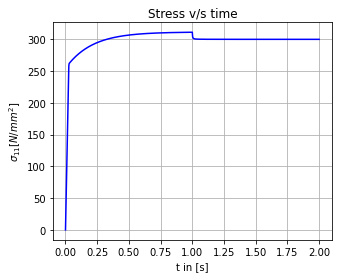

In [11]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, store_values[:,0], color = 'blue')

ax.set_title(r'Stress v/s time')
ax.set_xlabel('t in [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

plt.show()

# Isotropic and Kinematic Hardening

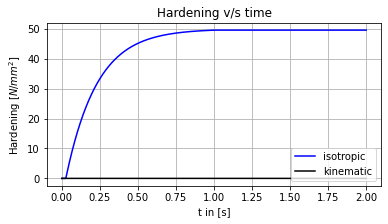

In [12]:
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(T, store_values[:,1], color = 'blue', label = 'isotropic')
ax.plot(T, store_values[:,2], color = 'black', label = 'kinematic')

ax.set_title(r'Hardening v/s time')
ax.set_ylabel(r'Hardening $[N/mm^2]$')
ax.set_xlabel('t in [s]')
ax.legend(loc = 'lower right')
ax.grid()

plt.show()

# Strain vs time

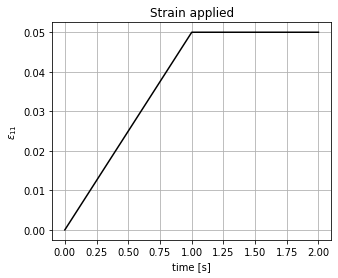

In [13]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(T, strain_linspace, color = 'black')

ax.set_title(r'Strain applied')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\varepsilon_{11}$')
ax.grid()

plt.show()

# Stress vs Strain

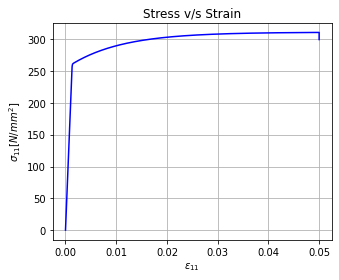

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(strain_linspace, store_values[:,0], color = 'blue')

ax.set_title(r'Stress v/s Strain')
ax.set_xlabel(r'$\varepsilon_{11}$')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')

ax.grid()
plt.show()